In [28]:
from pathlib import Path

import corr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [29]:
pth = Path("../../data/low_movement/Experiment-746czi")


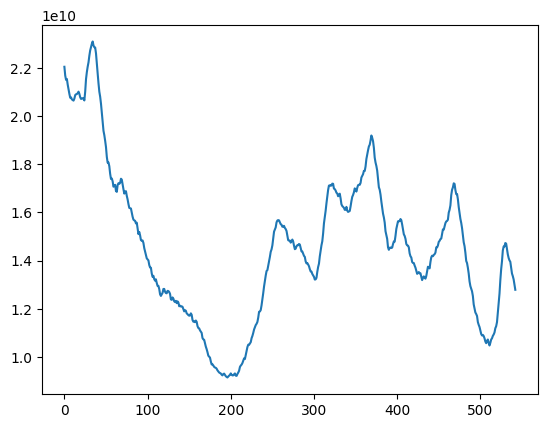

template_index=34


In [34]:
pattern = r"frame_*.tif"
frame_paths = list(pth.glob(pattern))
if not frame_paths:
    error_msg = f"No files found matching {pattern}"
    raise FileNotFoundError(error_msg)
frame_paths = [x.as_posix() for x in frame_paths]
frame_paths.sort()
frames = [np.array(Image.open(path)).astype(np.float32) for path in frame_paths]
frames = np.asarray(frames)
template_index = corr.find_highest_correlation(frames, plot=True)
template = frames[template_index]
print(f"{template_index=}")


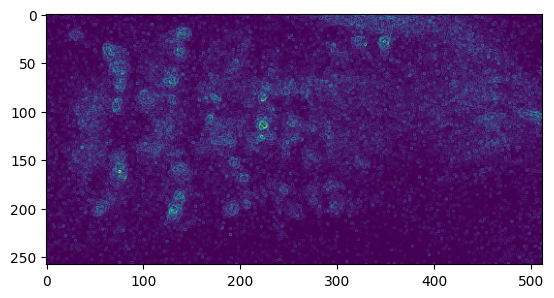

In [31]:
magnitude = corr.get_magnitude(template)
plt.imshow(magnitude)

In [32]:
ants_corrected = corr.ants_reg(frames, template_index)

100%|█████████████████████████████████████████████████████████████████████████████████████| 544/544 [11:55<00:00,  1.31s/it]


In [33]:
save_path = Path("../../data/cache/")
for i, arr in enumerate(ants_corrected):
    image = Image.fromarray(arr)
    image.save((save_path / f"ants_{i}.tiff").as_posix())

In [35]:
#ants_paths = list(save_path.glob("../../data/cache/ants*.tiff"))
#ants_paths = [x.as_posix() for x in ants_paths]
#ants_paths.sort()
#ants_corrected = [ants.image_read(ants_path) for ants_path in ants_paths]

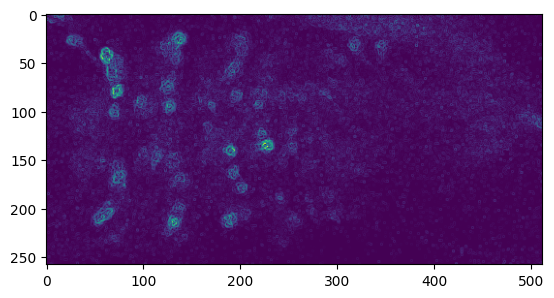

In [37]:
magnitude_template = corr.get_magnitude(template)
plt.imshow(magnitude_template)

In [38]:
len(ants_corrected)

544

In [41]:
mean_ssim, mean_gradient_ssim = corr.evaluate(ants_corrected, template)

100%|████████████████████████████████████████████████████████████████████████████████████| 544/544 [00:04<00:00, 130.47it/s]


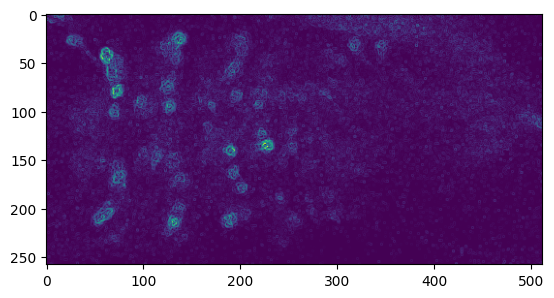

In [42]:
magnitude_template = corr.get_magnitude(template)
plt.imshow(magnitude_template)

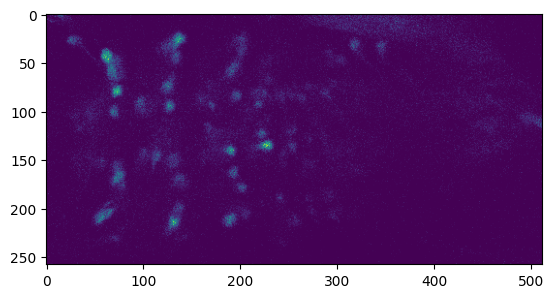

In [43]:
plt.imshow(template)

In [44]:
np.std(mean_ssim)

np.float64(0.060800611419418525)

In [45]:
np.std(mean_gradient_ssim)

np.float64(0.05718612241372256)

In [46]:
np.median(mean_ssim)

np.float64(0.610060363390861)

In [47]:
np.median(mean_gradient_ssim)

np.float64(0.4424488701817083)